Bruno VC Martins

This notebook was generated using Python3

Python version:  3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

-  Numpy version: 1.15.1
-  Pandas version: 0.23.4
-  Sklearn version: 0.19.2

# Data Scientist Nanodegree

# Project: Finding Donors for *CharityML*

## Supervised Learning

----
## Introduction

Income determination from publicly available data is a powerful tool for customer base identification. In this project we employed several supervised learning algorithms to infer individual income using the 1994 census data sample contained in the Adults dataset [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income) This datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_.

## Objective

The goal of this project was to build a model capable of predicting whether an individual makes more or less than $50,000 annually. Using this model, we would like to determine which census features are the most important for income prediction.

The analysis was carried out along the following steps:

- Perform EDA to check for missing data and possible correlations
- Preprocess the dataset and divide it into training and testing subsets
- Test several supervised learning models and choose the one leading to higher prediction score
- Optimize the hyperparameters of the model
- Perform feature importance analysis to determine which features were the most relevant for income prediction.  

----
## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Load the Census dataset
data = pd.read_csv("data/census.csv")
data.head(n=5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [6]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K']['income'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K']['income'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Note:** The dataset is imbalanced with a ratio of 3:1 between classes. Accuracy score is not a reliable metric.

___
### Features 

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

#### Pairplot Analysis

- None of the distirbutions are Normal
- Most of the feature combinations are not correlated or show weak correlation
- Capital-gain and Capital-loss show outliers

<Figure size 1152x1152 with 0 Axes>

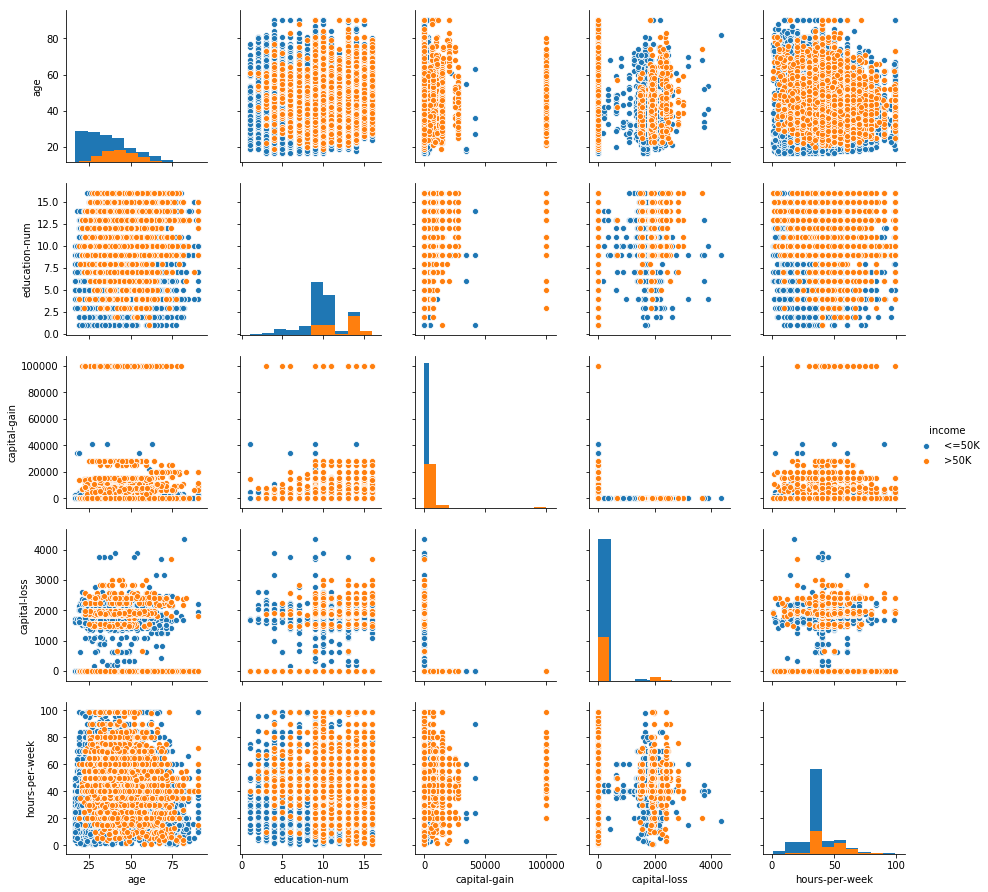

In [7]:
plt.figure(figsize=(16,16))
sns.pairplot(data, hue='income', diag_kind='hist');
plt.show()

In [8]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


#### Correlation Analysis

- As seen in the pairplot, we could not observe any relevant correlation between numerical variables.

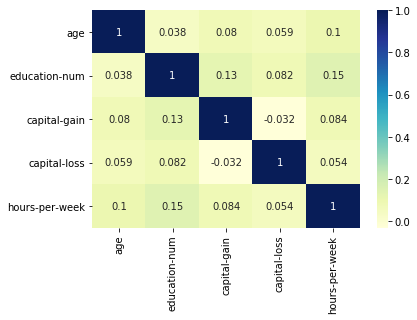

In [9]:
# Pearson's correlation coefficient for numerical variables
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu");

----
## Preparing the Data
The first step of data preparation consisted in separating the target (income) from the other features. Two classification levels were created:

- income higher that \$50,000 
- income at most \$50,000

### Skewed continuous features

We applied a logarithmic transformation to reduce the range of variables 'capital-gain' and 'capital-loss'. This is not strictly necessary and for this dataset it doesn't imply in significant prediction improvement.

In [10]:
# Split the data into features and target label
income_raw = data['income'] # separate target from predictors
features_raw = data.drop('income', axis = 1)

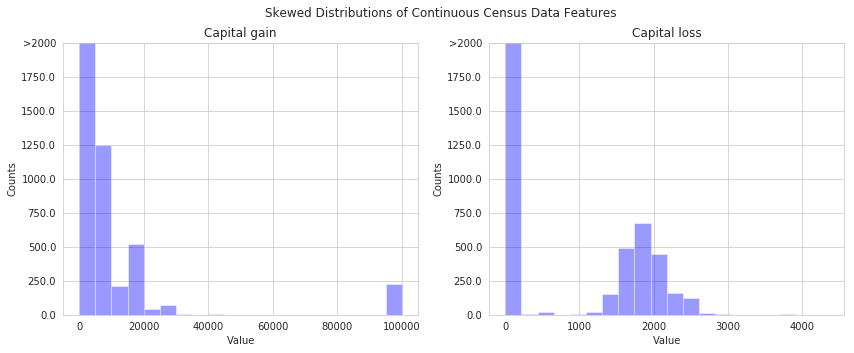

In [48]:
# Visualization of skewed distributions
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 5))
    ax1.set_ylim([0,2000])
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Counts')
    plt.suptitle('Skewed Distributions of Continuous Census Data Features')
    sns.distplot(data['capital-gain'], 
                 bins=20, 
                 kde=False, 
                 color='blue', 
                 ax=ax1, 
                 axlabel='Value').set_title('Capital gain')
    
    labels=ax1.get_yticks().tolist()
    labels[-1]='>2000'
    ax1.set_yticklabels(labels)
    
    ax2.set_ylim([0,2000])
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Counts')
    sns.distplot(data['capital-loss'], 
                 bins=20, 
                 kde=False, 
                 color='blue',
                 ax=ax2, 
                 axlabel='Value').set_title('Capital loss')
    
    labels=ax2.get_yticks().tolist()
    labels[-1]='>2000'
    ax2.set_yticklabels(labels)

In [12]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))


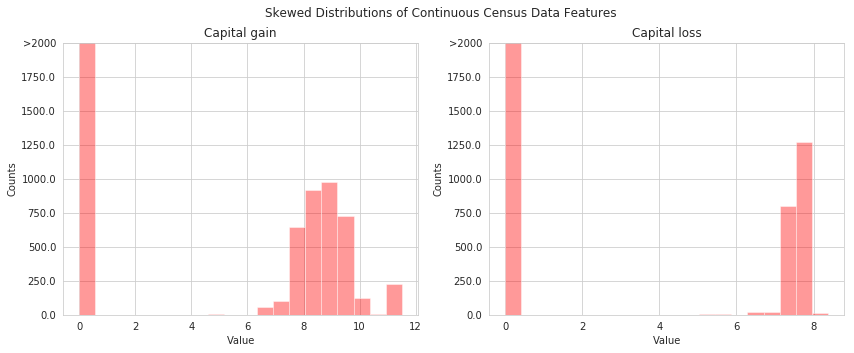

In [13]:
# Visualization of transformed distributions
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 5))
    ax1.set_ylim([0,2000])
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Counts')
    plt.suptitle('Skewed Distributions of Continuous Census Data Features')
    sns.distplot(features_log_transformed['capital-gain'],
                 bins=20, 
                 kde=False, 
                 color='red',
                 ax=ax1, 
                 axlabel='Value').set_title('Capital gain')
  
    
    labels=ax1.get_yticks().tolist()
    labels[-1]='>2000'
    ax1.set_yticklabels(labels)
    
    ax2.set_ylim([0,2000])
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Counts')
    sns.distplot(features_log_transformed['capital-loss'], 
                 bins=20, 
                 kde=False, 
                 color='red',
                 ax=ax2, 
                 axlabel='Value').set_title('Capital loss')
    
    labels=ax2.get_yticks().tolist()
    labels[-1]='>2000'
    ax2.set_yticklabels(labels)

### Normalizing Numerical Features

After applying the log transformation to skewed features, we normalized the numerical features using MinMaxScaler(). StandardScaler() could also have been used, despite implying in features like age having negative elements.

In [14]:
# Initialize scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

features_log_minmax_transform.head(n = 5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Preprocessing categorical data

In [15]:
# One-hot encode 
features_final = pd.get_dummies(features_log_minmax_transform)
income = income_raw.map(lambda x: 0 if x=='<=50K' else 1)

encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data

Split features and labels into training and testing sets with shuffling.

In [16]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2,
                                                    shuffle = True, 
                                                    random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

In this section, we investigated four different algorithms, and determined which resulted in the best model based on the F1 score.

### Naive predictor

We first defined a naive predictor as a baseline for comparison with learning models. This model predicts '>50k'for all inputs.

In [17]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
TP = np.sum(income)
FP = income.count() - TP 
TN = FN = 0
#Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN) # recall = 1
precision = TP / (TP + FP) # precision = accuracy

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ( recall + (precision * beta**2))
# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

We trained the following models:

- Decision Tree
- AdaBoostClassifier
- LogisticRegression


### Justification for the methods

### Logistic Regression

-  Real-world application: one of the main applications is medical research<sup>1</sup>. It is applied to classification problems involving numerical features (e.g. time of exposure to a drug) and the outcome is a binary variable stating if treatment was successful or not succesful.

-  Strengths of the model: this model is a variation of Linear Regression and it is therefore very simple to train. It is also very intuitive and it demands little hyperparameter tuning. It can handle categorical variables as well as numerical ones. Multinomial logistic regression, which is an extension of the basic model, can handle multivariate target classes.

- Weaknesses of the model: the decision bounday is linear and this can severily limit its performance treating data with multiple features separated by complex boundaries. Morevoer, because some of the independent variables are correlated, multicollineatiry will hinder a proper understanding of feature analysis.

-  Why is this a good candidate? This is a very flexible model that can handle both categorical and numerical variables as is the case for this dataset. It was chosen as a baseline for the performance of the more complex methods.

___
<sup>1</sup> Bernard Rosner. Fundamentals of Biostatistics 7th edition. Brooks/Cole, 2010.

### Decision Trees

-  Real-world application: among several decision-making applications, decision trees can be applied as a financial tool for loan granting decisions <sup>1</sup>.

-  Strengths of the model: this model can be used for both classification and regression tasks (binary and multinomial) with complex datasets. The criteria for the definition of the classification boundaries can be inspected and studied since the actual decision tree can be plotted as a directed graph.

-  Weaknesses of the model: decision trees are prone to overfitting. In general decision trees are used as components of ensemble methods.

-  Why is this model a good candidate? This is also a flexible model that can handle a dataset containing multiple mixed features (numeric and categorical) that might require non-linear decision boundaries for classification. It is also a computationally inexpensive model that will probably outperform ensemble methods for small datasets.
____
<sup>1</sup> Jozef Zurada. Could Decision Trees Improve the Classification Accuracy and Interpretability of Loan Granting Decisions? Proceedings of the 43rd Hawaii International Conference on System Sciences - 2010. Hawaii, IEEE Xplore. 

### Ensemble Methods - Ada Boost

-  Real-world application: AdaBoost is one of the most import classification and regression methods in Machine Learning. Among several application, a particularly interesting one is  person recognition <sup>1</sup>. This is the problem of verifying the identity of a person, mainly for security reasons.

-  Strengths of the model: Because it has few hyperparameters optimization using Grid Search can be done more easily than with similar ensemble methods. It is less succeptible to overfitting than other ensemble methods <sup>2</sup>.

- Weaknesses of the model: Training can be very time consuming because the method requires several weak learners.

- Why is this model a good candidate? Because it is one of the most powerful Supervised Learning methods. It builds up on the strength of Decision Trees and its capability of dealing with non-linear boundaries while avoiding the overfitting of a complex dataset. 

___
<sup>1</sup> Nikunj C. Oza, Kagan Turner. Classifier Ensembles: Select real-world applications. Information Fusion 9 (1): 4-20, 2008

<sup>2</sup> Aur&eacute;lien G&eacute;ron. Hands-On Machine Learning with Scikit-Learn & TensorFlow. O'Reilly Media Inc, 2009.

### Why I am not usign the other methods:

- Gaussian Naive Bayes: in principle we could apply Bayesian Statistics for this analysis but numerical and categorical variables would require different training aproaches. While GaussianNB could be used for numerical features, MultinomialNB would be better suited for categorical features. This method split adds another complexity layer to the solution that will probably not imply in improved performace over ensemble methods.

- K-Nearest Neighbours: this method is metric-based and it is not directly applicable to non-ordinal categorical data, as is the case for most of the categorical features in this dataset.

- Support Vector Machines (SVM): this method is also metric-based and therefore not directly applicable to non-ordinal categorical data. Moreover, our data preprocessing used one-hot encoding which greatly expanded the dimensions of the space of solutions turning this method prohibitivily expensive.

- Stochastic Gradient Descent: in principle this method could be applied to this problem. However, its basic loss function defaults to a linear SVM. Therefore, we can expect that this method would suffer from the same issues discussed above for SVM.

### Training and Predicting Pipeline

To properly evaluate the performance of the models we defined a training and predicting pipeline that validates the results using cross-validation.

In [18]:
def trainPredict(model, sample_size, X_train, y_train):
    '''
    This function trains and evaluates a model using a defined sample size.

    INPUT:
        model - instantiated sklearn model
        sample_size - number of entries to be taken from training set
        X_train - numpy array or pandas dataframe with training features
        y_train - numpy array or pandas dataframe with target values
    OUTPUT:
        results - dictionary containing the performance parameters for the model
    ''' 
    
    results = {}
    
    # shuffle training and target data and return array with n_samples elements
    X_train_shuffled, y_train_shuffled = shuffle(X_train.values, 
                                                 y_train.values, 
                                                 n_samples = sample_size)
    
    # fit training data and measure time
    start = time()
    model.fit(X_train_shuffled, y_train_shuffled)
    end = time()
    results['train_time'] = end - start
    
    # predict using the first 300 elements of training set and measure time
    start = time()
    predictions_train = model.predict(X_train[:300])
    # evaluate accuracy and F1 scores using 3-fold cross-validation
    # I cannot use X_test here because this is still a step of model selection
    accuracy_crossval = cross_val_score(model, 
                                        X_train_shuffled, 
                                        y_train_shuffled, 
                                        cv=3, 
                                        scoring='accuracy')
    f1_crossval = cross_val_score(model, 
                                  X_train_shuffled, 
                                  y_train_shuffled, 
                                  cv=3, 
                                  scoring='f1')
    end = time()
    results['pred_time'] = end - start
    
    # calculate accuracy using the first 300 entries of training set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    # average accuracy score calculated using 3-fold cross validation
    results['acc_cv'] = accuracy_crossval.mean()
    # compute F1 score using the first 300 samples of training set
    results['f1_train'] = fbeta_score(y_train[:300], predictions_train, beta=1.0)
    # average F1 score calculated using 3-fold cross validation
    results['f1_cv'] = f1_crossval.mean()
    print("{} trained on {} samples".format(model.__class__.__name__, sample_size))
    
    return results

### Model instantiation and assessment

In [19]:
# Intantiate the models
clf_A = DecisionTreeClassifier(random_state=34)
clf_B = AdaBoostClassifier(random_state=34)
clf_C = LogisticRegression(random_state=34)

In [20]:
# Calculate number of entries corresponding to 1%, 10%, 100% of total entries
# 1% of training entries
samples_1 = int(0.01 * X_train.shape[0]) 
# 10% of training entries
samples_10 = int(0.1 * X_train.shape[0])
# 100% of training entries
samples_100 = X_train.shape[0]

In [21]:
# Collect results on the learners
results = {}

for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name]={}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = trainPredict(clf, samples, X_train, y_train)

DecisionTreeClassifier trained on 361 samples
DecisionTreeClassifier trained on 3617 samples
DecisionTreeClassifier trained on 36177 samples
AdaBoostClassifier trained on 361 samples
AdaBoostClassifier trained on 3617 samples
AdaBoostClassifier trained on 36177 samples
LogisticRegression trained on 361 samples
LogisticRegression trained on 3617 samples
LogisticRegression trained on 36177 samples


In [22]:
# Metrics visualization for the supervised learning process
# first convert dict to pandas dataframe
df2 = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys() 
                              for j in results[i].keys()}, orient='index')
df2.reset_index(inplace=True)
d2 = {0:'1%',1:'10%',2:'100%'}
df2['dataP'] = df2['level_1'].map(d2)
df2.rename(index=str, columns={'level_0':'model'}, inplace=True)

In [23]:
df2

,model,level_1,train_time,pred_time,acc_train,acc_cv,f1_train,f1_cv,dataP
0,AdaBoostClassifier,0,0.051073,0.323467,0.823333,0.811700,0.589147,0.608206,1%
1,AdaBoostClassifier,1,0.168253,0.838140,0.833333,0.845174,0.590164,0.648542,10%
2,AdaBoostClassifier,2,2.596703,9.869282,0.850000,0.855516,0.621849,0.676677,100%
3,DecisionTreeClassifier,0,0.001685,0.012663,0.766667,0.797796,0.533333,0.576112,1%
4,DecisionTreeClassifier,1,0.019030,0.081264,0.813333,0.809243,0.605634,0.598077,10%
5,DecisionTreeClassifier,2,0.450121,1.697295,0.970000,0.812173,0.934307,0.615884,100%
6,LogisticRegression,0,0.503366,0.016614,0.813333,0.814440,0.575758,0.536554,1%
7,LogisticRegression,1,0.019272,0.088692,0.843333,0.831350,0.617886,0.643000,10%
8,LogisticRegression,2,0.212142,0.810038,0.846667,0.841723,0.622951,0.651585,100%


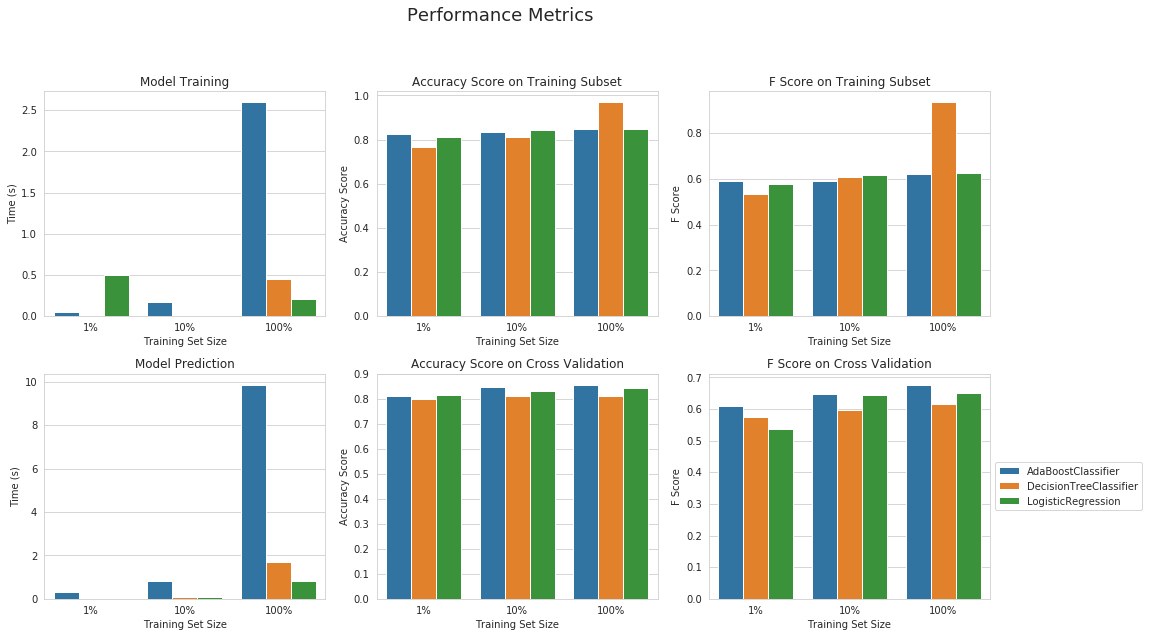

In [24]:
# then plot using Seaborn
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    f, axes = plt.subplots(2,3, figsize=(14,8))
    plt.suptitle('Performance Metrics', y=1.1, fontsize=18)
    sns.barplot(x='dataP',y='train_time',hue='model',data=df2, ax=axes[0][0])
    axes[0][0].set_title('Model Training')
    axes[0][0].set_xlabel('Training Set Size')
    axes[0][0].set_ylabel('Time (s)')
    axes[0][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_train',hue='model',data=df2, ax=axes[0][1])
    axes[0][1].set_title('Accuracy Score on Training Subset')
    axes[0][1].set_xlabel('Training Set Size')
    axes[0][1].set_ylabel('Accuracy Score')
    axes[0][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_train',hue='model',data=df2, ax=axes[0][2])
    axes[0][2].set_title('F Score on Training Subset')
    axes[0][2].set_xlabel('Training Set Size')
    axes[0][2].set_ylabel('F Score')
    axes[0][2].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='pred_time',hue='model',data=df2, ax=axes[1][0])
    axes[1][0].set_title('Model Prediction')
    axes[1][0].set_xlabel('Training Set Size')
    axes[1][0].set_ylabel('Time (s)')
    axes[1][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_cv',hue='model',data=df2, ax=axes[1][1])
    axes[1][1].set_title('Accuracy Score on Cross Validation')
    axes[1][1].set_xlabel('Training Set Size')
    axes[1][1].set_ylabel('Accuracy Score')
    axes[1][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_cv',hue='model',data=df2, ax=axes[1][2])
    axes[1][2].set_title('F Score on Cross Validation')
    axes[1][2].set_xlabel('Training Set Size')
    axes[1][2].set_ylabel('F Score')
    axes[1][2].get_legend().set_visible(False)
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))

----
## Model analysis

- AdaBoost had the best cross-validation performance for all dataset sizes
- Decision Tree and Logistic regression performed well with just the training set (probably overfitting)
- AdaBoost had by far the longest training time. However, it was still in the seconds range, so this comparison has no practical significance.

### Chosen model:


#### Adaboost was chosen the model to be used for the rest of this analysis. It had the best scores with the cross-validated set and it showed no signs of overfitting.

-  accuracy score with full training set: 0.856
-  F1 score with full training set: 0.678

### Model Tuning

In [25]:
# Initialize the classifier
clf = AdaBoostClassifier(random_state=34)

# Create the parameters list you wish to tune, using a dictionary if needed.

parameters = {"n_estimators": np.arange(100,1000,200),
            "learning_rate": np.arange(0.1,2.0,0.2)
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0)
# I could have used f1 directly. There was no major advantage with using f0.5

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters, cv=3, scoring=scorer, n_jobs=1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
clf_accuracy = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
clf_f1 = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1').mean()

best_accuracy = cross_val_score(best_clf, X_train, y_train, cv=3, scoring='accuracy').mean()
best_f1 = cross_val_score(best_clf, X_train, y_train, cv=3, scoring='f1').mean()

In [26]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score: {:.4f}".format(clf_accuracy))
print("F-score: {:.4f}".format(clf_f1))
print("\nOptimized Model\n------")
print("Final accuracy: {:.4f}".format(best_accuracy))
print("Final F-score: {:.4f}".format(best_f1))

Unoptimized model
------
Accuracy score: 0.8559
F-score: 0.6774

Optimized Model
------
Final accuracy: 0.8690
Final F-score: 0.7139


In [27]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.1000000000000003, n_estimators=900,
          random_state=34)

## Application of model to Test dataset

We chose the model and optimized it. Now we can use the test dataset for model assessment using a diverse collection of metrics.

In [28]:
y_pred = (best_clf.fit(X_train, y_train)).predict(X_test)

In [29]:
print("Final model - test set\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, y_pred, beta = 1.0)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, y_pred)))

Final model - test set
------
Accuracy score on testing data: 0.8681
F-score on testing data: 0.7032
Precision score on testing data: 0.7789
Recall score on testing data: 0.6408


In [30]:
confusion_matrix(y_test, y_pred)

array([[6439,  401],
       [ 792, 1413]])

**Note:** The model is tilted towards high precision and low recall. It is worthy noting the high number of false negatives that might have been caused by incorrect stratification of testing data.

### ROC curve for best model

In [31]:
y_proba = best_clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])

In [32]:
roc_auc = auc(fpr, tpr)
print('The area under the ROC curve is: ',roc_auc)

The area under the ROC curve is:  0.9268598082507856


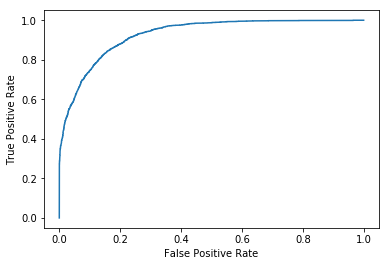

In [40]:
plt.plot(fpr, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Final Model Evaluation

#### Results for training:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.8576     |       0.8681    |
| F-score        |        0.7246     |   0.7467        |

The optimized scores are slightly better than the unoptmized ones. One option to increase these scores would be to optimize the individual trees used by AdaBoost.  

The results for the naive predictor were:

-  Accuracy Score: 0.2478
-  F-score: 0.2917

The final results for the testing set were:

- Accuracy Score: 0.8681
- F-score: 0.7032

The model led to better results than random guessing. Despite a high accuracy score, which is misleading given the imbalance of the dataset, we obtained a F1 score of 0.7. Improvements on this score are possible with improved hyperparameter search and with the use of proper stratification of training and testing data.

----
## Feature Importance

The final objective of this project was to determine which features were the most important for income determination. By focusing our analysis on a restricted subset of the features, we can get better insights about the mechanism underlining the prediction and also optimize the calculations.

For this censues dataset, since Income is the target attribute, we expected the following five attributes to be the most important in descending order:

1.  occupation
2.  capital-gain
3.  education-num
4.  age
5.  marital-status

Occupation and capital-gain have an obvious relationship with income. Education, specially college graduation, is also a good predictor since it determines the pool of high quality job positions available. Age can play a role if linked with career progression and marital-status is relevant since married couples will have higher combined household income.


### Extracting Feature Importance

We extracted a top five list of most important features from the best model trained above - AdaBoost. Tree-based models return feature importance as one of its outputs, so we didn't need to apply a specific method like RFE of k-best.

In [34]:
model = best_clf
model.fit(X_train, y_train)

# Extract feature importances using .feature_importances_ 
importances = model.feature_importances_

In [35]:
# Construct dataframe containing feature labels and their weights
feature_importances = pd.DataFrame(importances, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [36]:
feature_importances.reset_index(inplace=True)
feature_importances.head()

,index,importance
0,capital-gain,0.407778
1,capital-loss,0.375556
2,age,0.062222
3,hours-per-week,0.035556
4,education-num,0.008889


In [37]:
# Add cumulative sum of weights as a separate column
feature_importances['cumsum'] = np.cumsum(feature_importances['importance'])

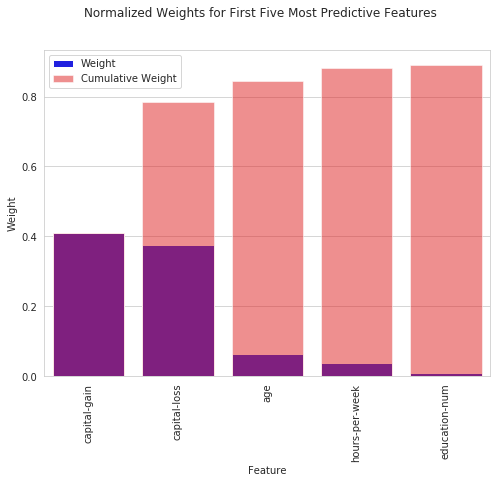

In [38]:
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    fig, axis = plt.subplots(1,1, figsize=(8,6))
    plt.suptitle('Normalized Weights for First Five Most Predictive Features')
    sns.barplot(x='index',
                y='importance',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='blue', 
                ci=None, label='Weight')
    sns.barplot(x='index',
                y='cumsum',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='red', 
                alpha=0.5, 
                ci=None, label='Cumulative Weight')
    plt.xticks(rotation=90)
    plt.legend()
    axis.set_xlabel('Feature')
    axis.set_ylabel('Weight')

### Most important features

The model classified the following features, in descending order, as the most important for income prediction:

1. capital-gain
2. capital-loss
3. age
4. hours-per-week
5. education-num

Considering our initial guess, we got three out of five classes correctly. Capital-loss is related to capital-gain and hours-per-week is a good predictor for high-paying executive jobs. However, it was surprising that occupation did not appear in the top five list. 

### Reduced model

Finally, we retrained our model using only the top 5 most important features. From the figure above, we noticed that these most important features contributed more than half of the importance of all features present in data. Therefore we expected them to retain most of the relevant information in the model. 

In [42]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, y_pred, beta = 1.0)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 1.0)))
print("Model training time: {:.3f}".format(end-start))

Final Model trained on full data
------
Accuracy on testing data: 0.8681
F-score on testing data: 0.7032

Final Model trained on reduced data
------
Accuracy on testing data: 0.8426
F-score on testing data: 0.5936
Model training time: 9.132


### Effects of Feature Selection

The model trained on reduced data had a very poor performance considering the F1 score.

One possible reason for the difference between tmodels was that education-num was weakly correlated to hours-per-week and to capital-gain. That might have affected the feature selection process. Perhaps a dimension reduction technique like PCA or LDA would have been more effective in improving the model.

## Conclusions

- AdaBoost was the best performer classifier for this mixed-variables model
- Logistic regression also performed well and with a better training performance
- The model successfully predicted income with high accuracy and F1 scores based only on census variables